In [2]:
'''
Training Data is a N*T*n tensor, N is the number of samples, T is the interval,
n is number of neurons.
Training Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the
output dimension, which is the position of last time point.
Testing Data is a N'*T*n tensor.
Testing label is a N*1*1 tensor.
E.g.,
TrainingData = create_subsequences(np.transpose(X, TimeInterval))
TrainingLabel = Y[TimeInterval-1:].reshape(-1,1)
X is dFF, Y is corresponding position.
'''

"\nTraining Data is a N*T*n tensor, N is the number of samples, T is the interval,\nn is number of neurons.\nTraining Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the\noutput dimension, which is the position of last time point.\nTesting Data is a N'*T*n tensor.\nTesting label is a N*1*1 tensor.\nE.g.,\nTrainingData = create_subsequences(np.transpose(X, TimeInterval))\nTrainingLabel = Y[TimeInterval-1:].reshape(-1,1)\nX is dFF, Y is corresponding position.\n"

In [31]:
import torch, os, glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
import scipy, pandas as pd, random
from sklearn.preprocessing import MinMaxScaler

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim = 256, 
        output_dim = 1, 
        num_layers = 2):
        # hidden_dim = height of network
        # layers = wifth of network
        super(LSTMModel, self).__init__()
        # Initialize the LSTM, Hidden Layer, and Output Layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                dropout = 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        
        return out

def create_subsequences(time_series, subsequence_length=20):
    num_subsequences = len(time_series) - subsequence_length + 1
    subsequences = [time_series[i:i+subsequence_length] for i in range(num_subsequences)]
    return np.array(subsequences)

class CreateTimeSeriesData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [24]:
# import raw data
with open("Z:\dcts_com_opto_inference.p", "rb") as fp: #unpickle
        dcts = pickle.load(fp)
# can be different depending on model version
conddf = pd.read_csv(r"Z:\condition_df\conddf_neural_com_inference.csv", index_col=None)

In [68]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["xtick.major.size"] = 8
mpl.rcParams["ytick.major.size"] = 8
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

def run_inference_optoep_for_vis(conddf, dd, dcts,
            savepth = r'Z:\\models_lstm_all_cells', 
savedst = r'C:\Users\Han\Box\neuro_phd_stuff\han_2023-\thesis_proposal'
):    
    """
    run inference on opto ep and get error
    """
    savepth = glob.glob(os.path.join(savepth, f'model_dd{dd:03d}*'), recursive=True)[0]
    if os.path.exists(savepth):
        day=conddf.days.values[dd]
        animal = conddf.animals.values[dd]
        params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
        print(params_pth)
        fall = scipy.io.loadmat(params_pth, variable_names=['dFF', 'forwardvel', 
                        'ybinned', 'iscell',
                        'trialnum', 'bordercells', 'changeRewLoc', 'licks', 'VR'])
        VR = fall['VR'][0][0]
        try:
            gainf = VR[14][0][0]
            rewsize = VR[16][0][0][4][0][0]/gainf
        except:
            gainf = VR[15][0][0] # opto days have additional variables in vr
            rewsize = VR[17][0][0][4][0][0]/gainf
        changeRewLoc = np.hstack(fall['changeRewLoc']) 
        eptest = conddf.optoep.values[dd]
        eps = np.where(changeRewLoc>0)[0]
        rewlocs = changeRewLoc[eps]
        eps = np.append(eps, len(changeRewLoc)) 
        if conddf.optoep.values[dd]<2: 
            eptest = random.randint(2,3)   
            if len(eps)<4: eptest = 2 # if no 3 epochs
        trialnum = np.hstack(fall['trialnum'])
        try:
            comp = [int(savepth[-17:-16]), int(savepth[-15:-14])] # eps to compare    
        except:
            comp = [int(savepth[-16:-15]), int(savepth[-14:-13])]
        other_ep = [xx for xx in range(len(eps)-1) if xx not in comp]
        # filter iscell
        dff = fall['dFF'][:,(fall['iscell'][:,0].astype(bool)) & (~fall['bordercells'][0].astype(bool))]
        # remove nans
        dff[:, sum(np.isnan(dff))>0] = 0
        # position mask 
        # NOTE: excl reward location            
        position = fall['ybinned'][0]
        position_per_ep = [position[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]               
        # exclude rew zone
        dff_per_ep = [dff[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
                (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))]
            for xx in range(len(eps)-1)]        
        trialnum_per_ep = [trialnum[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
                (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))] for xx in range(len(eps)-1)]
        # get a subset of trials
        dff_per_ep_trials = [dff_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        dff_per_ep_trials_test = [dff_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        # get a subset of trials
        position_per_ep_trials = [position_per_ep[ii][(position_per_ep[ii]<rewlocs[ii]-(.5*rewsize)) |
                (position_per_ep[ii]>rewlocs[ii]+(.5*rewsize))][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        position_per_ep_trials_test = [position_per_ep[ii][(position_per_ep[ii]<rewlocs[ii]-(.5*rewsize)) |
            (position_per_ep[ii]>rewlocs[ii]+(.5*rewsize))][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        # licks
        licks = fall['licks'][0]
        licks_per_ep = [licks[eps[xx]:eps[xx+1]][(position_per_ep[xx]<rewlocs[xx]-(.5*rewsize)) | 
            (position_per_ep[xx]>rewlocs[xx]+(.5*rewsize))] for xx in range(len(eps)-1)]
        # get a subset of trials
        licks_per_ep_trials = [licks_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        licks_per_ep_trials_test = [licks_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        #prepare variables 
        TimeInterval = 15 # frames
        # run inference on opto epoch
        test = dff_per_ep_trials[comp[1]]
        if len(test)>0: # check if enough trials exists.
            test_pos = position_per_ep_trials[comp[1]]
            lick = licks_per_ep_trials[comp[1]]
            TestLabel = test_pos[TimeInterval-1:].reshape(-1,1)
            TestData = create_subsequences(test,TimeInterval)
            batch_size = 256
            input_size = TestData.shape[-1] # number of cells
            output_size = 1        
            Test_dataset = CreateTimeSeriesData(TestData, TestLabel)
            Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size,
                        shuffle=False, drop_last = True)        
            # load existing model                
            print(savepth)
            print(TestData.shape)
            model = LSTMModel(input_size, 
                output_dim = output_size)
            model.load_state_dict(torch.load(savepth))
            device = torch.device("cpu")
            model = model.to(device)
            criterion = nn.MSELoss()  # For regression tasks
            # criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
                        weight_decay = 1e-9)
            predict = []
            val_loss = 0
            for inputs, targets in Test_loader:
                # Forward pass
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                outputs = model(inputs)
                predict.append(outputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            print('Validation Loss: {:.4f}'.format(val_loss/len(Test_loader)))
            predict = np.concatenate([xx.cpu().detach().numpy() for xx in predict])
            predict_vis = np.squeeze(np.array(pd.DataFrame(predict).interpolate().rolling(50).mean().interpolate().values))
            pos = test_pos
            fig, axes = plt.subplots(1,3, figsize=(20,7))
            # 5625= 3 min
            axes[0].plot(pos[:5625], label='True position')
            axes[1].plot(predict_vis[:5625],color='darkorange', label='Predicted position')
            axes[2].plot(pos[:5625],label='True position')
            axes[2].plot(predict_vis[:5625],color='darkorange', label='Predicted position')
            axes[0].scatter(np.where(lick[:5625]>0)[0], pos[:5625][np.where(lick[:5625]>0)[0]], s=20, color='k',
                        label='Lick')
            axes[0].set_xlabel("Time (s)")
            axes[0].set_ylabel("Position (cm)")
            axes[0].legend()
            axes[1].legend()
            axes[2].legend()
            fig.suptitle(f'Animal: {animal}, Day: {day}, optoep: {conddf.optoep.values[dd]}')
            plt.savefig(os.path.join(savedst,rf'{animal}_{day}_prediction.svg'), bbox_inches='tight')
            plt.close(fig)
            # Compute the MAE and MSE on a test set            
            if pos.shape[0]>predict.shape[0]:
                pos = pos[:predict.shape[0]]
            mae = mean_absolute_error(pos, predict)
            mse = mean_squared_error(pos, predict)
            print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")
            return dd,[mse,mae]

In [69]:
# make models for all animals/days
from sklearn.metrics import mean_absolute_error, mean_squared_error
savepth = r'Z:\\models_lstm_all_cells_no_rew'
savedst = r'C:\Users\Han\Box\neuro_phd_stuff\han_2023-\thesis_proposal'
errors = []
dds = np.arange(5,len(conddf))#len(conddf))
dds_run = [] # grab the days that meet criteria
for dd in dds: #len(conddf)
    # if conddf.in_type.values[dd]=='vip':
    # try:
        dd,err = run_inference_optoep_for_vis(conddf,dd,dcts, savepth=savepth,
                        savedst=savedst)
        errors.append(err)
        dds_run.append(dd)
    # except Exception as e:
    #     print(e)

Y:\analysis\fmats\e218\days\e218_day044_plane0_Fall.mat
Z:\\models_lstm_all_cells_no_rew\model_dd005_epcompare0-1_e218_day44.pt
(23133, 15, 859)
Validation Loss: 3649.8578
MAE: 50.0441, MSE: 3861.4247
Y:\analysis\fmats\e218\days\e218_day047_plane0_Fall.mat
Z:\\models_lstm_all_cells_no_rew\model_dd006_epcompare1-2_e218_day47.pt
(16964, 15, 691)
Validation Loss: 1889.7155
MAE: 34.1462, MSE: 2558.5202
Y:\analysis\fmats\e218\days\e218_day048_plane0_Fall.mat
Z:\\models_lstm_all_cells_no_rew\model_dd007_epcompare0-1_e218_day48.pt
(22094, 15, 855)
Validation Loss: 2416.9053
MAE: 34.3577, MSE: 2674.9981
Y:\analysis\fmats\e218\days\e218_day049_plane0_Fall.mat
Z:\\models_lstm_all_cells_no_rew\model_dd008_epcompare0-1_e218_day49.pt
(9121, 15, 757)
Validation Loss: 1632.1349
MAE: 32.0028, MSE: 2661.3362
Y:\analysis\fmats\e218\days\e218_day050_plane0_Fall.mat
Z:\\models_lstm_all_cells_no_rew\model_dd009_epcompare0-1_e218_day50.pt
(11179, 15, 642)
Validation Loss: 1689.1991
MAE: 29.9976, MSE: 2532.2

                     mean_squared_error  mean_absolute_error        day
animals condition                                                      
e186    ctrl_ledoff         2066.993031            27.710887   3.500000
        ctrl_ledon          3352.326525            38.606953  34.714286
e189    ctrl_ledoff         2444.195872            34.187078  37.600000
        ctrl_ledon          3572.571514            41.372692  41.000000
e190    ctrl_ledoff         3346.382496            40.555531  37.000000
        ctrl_ledon          3068.232208            43.955930  42.500000
e200    ctrl_ledoff         3599.396886            38.935226  77.714286
        ctrl_ledon          4036.729012            43.671999  76.750000
e201    ctrl_ledoff         1707.093751            21.949446  60.666667
        ctrl_ledon          2192.596200            26.743452  64.571429
e216    vip_ledoff          3339.640765            39.586802   8.000000
        vip_ledon           2929.311727            40.246969  46

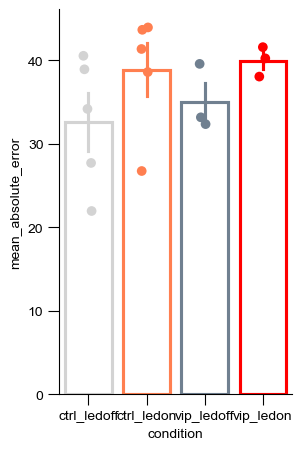

In [70]:
# quantify error
errors_arr = np.array(errors)
dds = np.array(dds_run)
df = pd.DataFrame()

df['mean_squared_error'] = errors_arr[:,0]
df['mean_absolute_error'] = errors_arr[:,1]
conddf_ = conddf.iloc[dds]
conddf_.reset_index(drop=True)
df['animals'] = conddf_.animals.values
df['in_type'] = conddf_.in_type.values
df['day'] = conddf_.days.values
# print(len(dds))
# print(len(errors))
# print(len(conddf_))
condition = []
for ii,ep in enumerate(conddf_.optoep.values):
    if conddf_.in_type.values[ii]=='vip' and ep<2:
        condition.append('vip_ledoff')
    elif conddf_.in_type.values[ii]=='vip' and ep>=2:
        condition.append('vip_ledon')
    elif conddf_.in_type.values[ii]!='vip' and ep<2:
        condition.append('ctrl_ledoff')
    elif conddf_.in_type.values[ii]!='vip' and ep>=2:
        condition.append('ctrl_ledon')
df['condition'] = condition
# df = df[(df.animals!='e190') & (df.animals!='e200')]
df = df.groupby(['animals', 'condition']).mean(numeric_only=True)
df.to_csv(r'C:\Users\Han\Desktop\test.csv')
print(df)

import seaborn as sns
plt.figure(figsize=(3,5))
ax = sns.barplot(x = 'condition', y = 'mean_absolute_error',
        hue = 'condition', data=df,
        fill=False, errorbar='se',
        palette={'vip_ledoff': "slategray", 'vip_ledon': "red",
                'ctrl_ledoff': "lightgray", 'ctrl_ledon': "coral"})
ax = sns.stripplot(x = 'condition', y = 'mean_absolute_error', 
        hue = 'condition', data=df,
        palette={'vip_ledoff': "slategray", 'vip_ledon': "red",
                'ctrl_ledoff': "lightgray", 'ctrl_ledon': "coral"},s=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(os.path.join(savedst, 'allcells_mean_abs_error_lstm.svg'), bbox_inches='tight')

t,pval = scipy.stats.ttest_rel(df.loc[(df.index.get_level_values('condition') == 'vip_ledoff'), 'mean_absolute_error'].values,
    df.loc[(df.index.get_level_values('condition') == 'vip_ledon'), 'mean_absolute_error'].values)
print(f'p-value vipLEDoff vs. LEDon = {pval}')
t,pval = scipy.stats.ranksums(df.loc[(df.index.get_level_values('condition') == 'ctrl_ledon'), 'mean_absolute_error'].values,
    df.loc[(df.index.get_level_values('condition') == 'vip_ledon'), 'mean_absolute_error'].values)
print(f'p-value vipLEDon vs. ctrlLEDon = {pval}')
# print(scipy.stats.ttest_ind(df.loc[df.condition == 'ctrl_ledon', 'mean_absolute_error'].values,
#     df.loc[df.condition == 'vip_ledon', 'mean_absolute_error'].values))
